In [1]:
cd /content/drive/MyDrive/Pytorch_and_cv/Assingment/Untrodden_Labs

/content/drive/MyDrive/Pytorch_and_cv/Assingment/Untrodden_Labs


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import ResNet50,VGG19,InceptionV3,MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy

In [3]:
img_gen = ImageDataGenerator(horizontal_flip=True,shear_range=.10,validation_split=0.20,
                             zoom_range=.10,rotation_range=20,width_shift_range=0.2,
                             height_shift_range=0.2)
train_gen = img_gen.flow_from_directory("casting_data/casting_data/train",subset='training',target_size=(200,200),
                                        batch_size=64,shuffle=True)
valid_gen = img_gen.flow_from_directory("casting_data/casting_data/train",target_size=(200,200),subset='validation',
                                       batch_size=32,shuffle=True)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.


In [ ]:
early_stop = EarlyStopping(monitor="val_loss",patience=1,verbose=1)

In [ ]:
with tf.device("/gpu:0"):
    res = MobileNet(input_shape=(200,200,3),include_top=False,weights="imagenet",classes=2)
    res.trainable = False
    for layer in res.layers:
        layer.trainable = False

    base_res = res
    base_out = base_res.output

    pool_out = Flatten()(base_out)

    hidden1 = Dense(512, activation='relu')(pool_out)
    drop1 = Dropout(rate=0.2)(hidden1)
    hidden2 = Dense(128, activation='relu')(drop1)
    drop2 = Dropout(rate=0.2)(hidden2)
    

    out = Dense(2, activation='sigmoid')(drop2)

    model1 = tf.keras.Model(inputs=base_res.input, outputs=out)
    model1.compile(optimizer="adam",
                    loss=binary_crossentropy,
                    metrics=['accuracy'])

17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
with tf.device("/gpu:0"):
  model1.fit_generator(train_gen,epochs=100,verbose=1,validation_data=valid_gen,callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
83/83 [==============================] - 95s 1s/step - loss: 1.8466 - accuracy: 0.5342 - val_loss: 0.6877 - val_accuracy: 0.5671
Epoch 2/100
83/83 [==============================] - 89s 1s/step - loss: 0.6766 - accuracy: 0.5868 - val_loss: 0.5994 - val_accuracy: 0.6041
Epoch 3/100
83/83 [==============================] - 90s 1s/step - loss: 0.6023 - accuracy: 0.6435 - val_loss: 0.5380 - val_accuracy: 0.7104
Epoch 4/100
83/83 [==============================] - 92s 1s/step - loss: 0.5528 - accuracy: 0.7072 - val_loss: 0.4903 - val_accuracy: 0.7376
Epoch 5/100
83/83 [==============================] - 89s 1s/step - loss: 0.4994 - accuracy: 0.7522 - val_loss: 0.4010 - val_accuracy: 0.8167
Epoch 6/100
83/83 [==============================] - 89s 1s/step - loss: 0.4580 - accuracy: 0.7797 - val_loss: 0.3750 - val_accuracy: 0.8213
Epoch 7/100
83/83 [==============================] - 88s 1s/step - loss: 0.4329 - accuracy: 0.8016 - val_loss: 0.3705 - val_accuracy: 0.8288
Epoch 8/100
8

In [ ]:
summary = pd.DataFrame(model1.history.history)

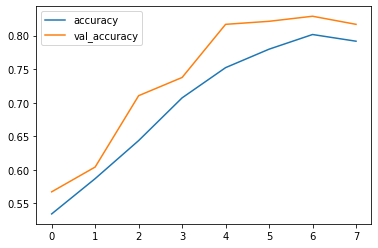

In [ ]:
summary[["accuracy","val_accuracy"]].plot()

In [ ]:
model1.save("mobilenet.h5")

In [32]:
test = image_dataset_from_directory("casting_data/casting_data/test",image_size=(200, 200),label_mode="categorical")

Found 715 files belonging to 2 classes.


In [10]:
model.evaluate(test)# first time 2min

23/23 [==============================] - 11s 426ms/step - loss: 0.0482 - accuracy: 0.9818


[0.048246316611766815, 0.9818181991577148]

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.models import load_model

In [4]:
model = load_model("mobilenetsmall.h5")

In [37]:
def show_prediction(image):
    RGB = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    label = ["Defective","Not Defective"]
    resize = cv2.resize(RGB,(200,200)).reshape(1,200,200,3)
    pred_per = model.predict(resize)
    pred_index = np.argmax(pred_per,axis=1)[0]

    txt = "Label: "+label[pred_index]
    output = cv2.putText(image.copy(),txt,(10,30),cv2.FONT_HERSHEY_PLAIN,2,[50,200,50],2)
    return output

In [42]:
def predict_tflite(image):
    interpreter.allocate_tensors()
    RGB = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    label = ["Defective","Not Defective"]
    resize = cv2.resize(RGB,(200,200)).reshape(1,200,200,3)
    test_imgs_numpy = np.array(resize, dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
    interpreter.invoke()
    pred_per = interpreter.get_tensor(output_details[0]['index'])
    pred_index = np.argmax(pred_per,axis=1)[0]

    txt = "Label: "+label[pred_index]

    output = cv2.putText(image.copy(),txt,(10,30),cv2.FONT_HERSHEY_PLAIN,2,[50,200,50],2)

    return output

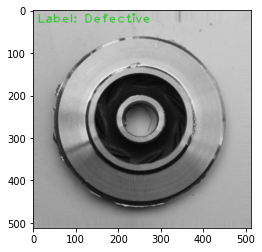

In [43]:
image = cv2.imread("casting_512x512/casting_512x512/def_front/cast_def_0_159.jpeg")
plt.imshow(show_prediction(image))

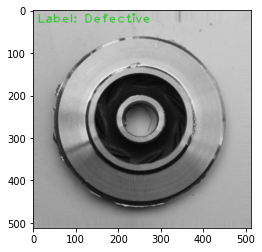

In [44]:
plt.imshow(predict_tflite(image))

In [11]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpw7mqlu1b/assets


In [ ]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

In [6]:
interpreter = tf.lite.Interpreter(model_path = "tf_lite_model.tflite")
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 200 200   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>


In [30]:
txt

'Label: Defective'

In [36]:
test

<BatchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>